In [1]:
# !pip install cv2
import sys
# !{sys.executable} -m pip install opencv-contrib-python
!pip install opencv-contrib-python

You should consider upgrading via the 'C:\Users\Kian Hui\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import cv2 # opencv library
import math

### First, we will open the video file

In [3]:
# video_cap = cv2.VideoCapture('Traffic_Laramie_1.mp4')
# bg_sub = cv2.createBackgroundSubtractorMOG2(history=12000, varThreshold=20, detectShadows = False)
# if not video_cap.isOpened():
#     print("Failed to open file")
#     exit()

### Properties of video file

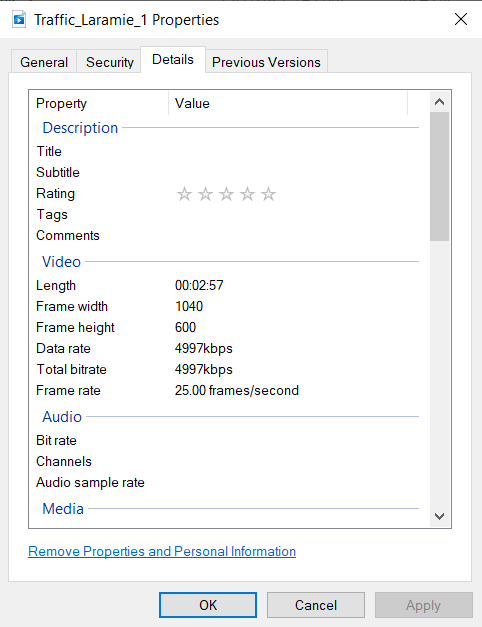

#### We can see that the video has a length of 2mins 57secs, frame dimension of 1040x600 with a frame rate of 25 frames/sec

to fix issue of recounting stopped cars, can consider adding [4] to tracked_objects and only remove the tracked object after 150 frames or any number

can include another param for tracked objects by checking previous x and current x value to see if they are going to left or right direction

In [4]:
def car_counter(video_cap, bg_sub):
    '''
    This algorithm achieves object tracking by using centroids of all moving objects with the contour area larger than 4700. 
    This area is found based on trial and error where all humans walking are not tracked while only cars are tracked.
    Further details are explained with the help of comments throughout the function.
    '''
    amount_of_frames = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # initialise previous frame centroids with empty list
    previous_frame_centroids = []

    # we will be using this dictionary to store tracked centroid information in the following index format:
    # [0] -> tracked centroid x value, [1] -> tracked centroid y value, [2] -> track id, [3] -> track status, 
    # track status will be used to decide if the "id" text should be drawn beside the contour
    tracked_objects = {}
    # first tracked car index = 0
    tracking_id = 0

    car_counter = 0

    for i in range(amount_of_frames):
        # list of centroids for object tracking in current frame
        current_frame_centroids = []

        ret, frame = video_cap.read()
        
        # define area to detect cars
        # height: 260 to 600, width: 0 to 1040 of the frame
        detection_area = frame[260:600,0:1040]

        # subtract background and detect objects
        fgmask = bg_sub.apply(detection_area)
        _, fgmask = cv2.threshold(fgmask, 254, 255, cv2.THRESH_BINARY)

        contours, _ = cv2.findContours(fgmask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for cnt in contours:
            area = cv2.contourArea(cnt)
            # greater than 4700 so that only contours for vehicles are tracked
            # groups of people walking together or cycling are found to be smaller than 4700 in this cases
            x, y, w, h = cv2.boundingRect(cnt)
            # it is found that overlapping vehicles from x value 0 to 520 and y greater than 130, have areas larger than 13500
            if x < 520 and area > 13500 and h > 130:
                # if contours overlap vertically
                # split and get centroid of both contours of overlapping cars
                # top car
                cx1 = int(x + (x + w) / 2)  
                cy1 = int(y + (y + h/2) / 2)
                # bottom car
                cx2 = int(x + (x + w) / 2)
                cy2 = int(y + h/2 + (y + h/2) / 2)

                # append centroid for both cars into centroids list
                current_frame_centroids.append((cx1, cy1))
                current_frame_centroids.append((cx2, cy2))

                # draw rectangle for both cars
                cv2.rectangle(detection_area, (x,y), (x + w, y + int(h/2)), (0, 255, 0), 1)
                cv2.rectangle(detection_area, (x,y + int(h/2)), (x + w, y + h), (0, 255, 0), 1)
                
            # elif no overlaps
            elif area > 4700:
                # get centroid of contour
                cx = int(x + (x + w) / 2)
                cy = int(y + (y + h) / 2)
                # append centroid info into list
                current_frame_centroids.append((cx, cy))
                # draw rectangle for car
                cv2.rectangle(detection_area, (x,y), (x + w, y + h), (0, 255, 0), 1)

        # assign or update tracking id to centroid 
        for ccentroid in current_frame_centroids:

            # we will be using this list to store centroid information in the following index format:
            # [0] -> centroid x value, [1] -> centroid y value, [2] -> distance, [3] -> tracking_id
            nearest_track_obj = []

            # iterate through tracked objects and find closest object
            # this loop will only run when there are objects added into the list of tracked_objects
            for object_key in tracked_objects:
                # retrieve tracked_obj using the key
                tracked_obj = tracked_objects[object_key]
                # for each iteration, calculate euclidean dist and find closest tracked object to centroid
                # sqrt( (x1 - x2)**2 + (y1 - y2)**2 )
                distance = math.sqrt( (tracked_obj[0]-ccentroid[0])**2 + (tracked_obj[1]-ccentroid[1])**2 )

                # if distance between the centroid and tracked object is smaller than 100,
                # they are likely to be the same object/car
                # this value may actually be smaller but for the purpose of this assignment, 
                # 100 is alright as it still works as intended
                if distance < 100:
                    # if there is already a new position candidate(nearest_track_obj != []), check if distance is shorter
                    # replace nearest_track_obj if conditions met
                    if nearest_track_obj != []:
                        # if nearest_track_obj distance is larger than new distance (current distance is shorter)
                        if nearest_track_obj[2] > distance:
                            # replace with current centroid
                            nearest_track_obj = [ccentroid[0], ccentroid[1], distance, tracked_obj[2]]
                    else:
                        # if no candidate centroid found previously, assign it to nearest_track_obj
                        nearest_track_obj = [ccentroid[0], ccentroid[1], distance, tracked_obj[2]]
                # if distance is >= 100, this tracked object is deemed to have become non visible from the frame
            
            # if no nearest track object is found, this object is deemed to be a new object,
            # therefore, track this new object
            if not nearest_track_obj:
                tracked_objects[tracking_id] = [ccentroid[0], ccentroid[1], tracking_id, True]
                tracking_id += 1
            else:
                # if there are new position candidates found, update the tracked object/car with the new centroid position
                # track_id to be updated
                update_track_id = nearest_track_obj[3]
                tracked_objects[update_track_id] = [ccentroid[0], ccentroid[1], update_track_id, True]

            # track status is set to True everytime an object is created or updated
            # track status is then set to false everytime the text is drawn (see below at "draw text" for loop section) 
                
            # reset nearest track object
            nearest_track_obj.clear()
    
        # draw text on each bounding rect
        for object_key in tracked_objects.copy():
            centroid = tracked_objects[object_key]
            # if track status is True
            if centroid[3] == True:
                
                cv2.putText(frame, str(centroid[2]), (centroid[0]-50, centroid[1]+250), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1, cv2.LINE_AA)
                # set status to false
                tracked_objects[centroid[2]] = [centroid[0], centroid[1], centroid[2], False]
            else:
                # track status == false, object exited from region of interest
                # remove from tracked objects dictionary as it is no longer tracked
                if centroid[0] < 215:
                    car_counter += 1
                del tracked_objects[centroid[2]]

        # print counter information
        cv2.putText(frame, 'Cars Going to City Center: ', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(frame, str(car_counter), (500, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 1, cv2.LINE_AA)
        
        cv2.imshow("Frame", frame)
        if cv2.waitKey(1) == ord('q'):
            break


    print("Total cars going to city center: " + str(car_counter))
    # as the duration of the video is 2:57, lets just assume that it is 3 minutes, therefore, total cars counted / 3
    print("Cars per minute: " + str(round(car_counter/3)))
        
    video_cap.release()
    cv2.destroyAllWindows()

In [5]:
# print('Traffic_Laramie_1.mp4 results:')
# car_counter(video_cap, bg_sub)

Traffic_Laramie_1.mp4 results:
Total cars going to city center: 6
Cars per minute: 2


### Next video file

In [6]:
video_cap = cv2.VideoCapture('Traffic_Laramie_2.mp4')
bg_sub = cv2.createBackgroundSubtractorMOG2(history=12000, varThreshold=20, detectShadows = False)
if not video_cap.isOpened():
    print("Failed to open file")
    exit()

### Properties of video file 2

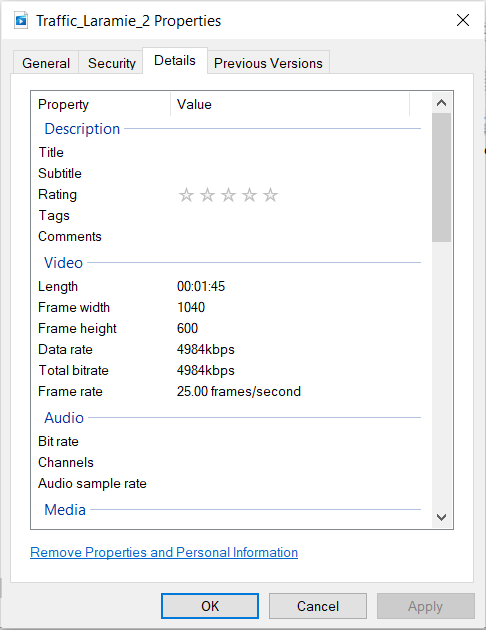

In [7]:
print('Traffic_Laramie_2.mp4 results:')
car_counter(video_cap, bg_sub)

Traffic_Laramie_2.mp4 results:
Total cars going to city center: 5
Cars per minute: 2
